In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import math
import numpy as np
import sklearn
from utils import *
from models.Cnn import *
from plot_cnn import *
%matplotlib inline
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from Shapley import ShapNN
from DShap_run import DShap
from shap_utils import *

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=True

#hyper parameters
batch_size = 1024
epochs = 30
noise_size = 50
train_size = 100
test_size = 100
pre_size = 2000
heldout_size = 1000

In [21]:
# load Tiny imagenet data
data = MNIST(one_hot=False, shuffle=False)
data.x_train[:noise_size] = add_noise(data.x_train[:noise_size], 1, 0.1, 'white')

x_train = np.reshape(data.x_train[:train_size], (train_size, -1))
y_train = data.y_train[:train_size]
x_test = np.reshape(data.x_train[-test_size:], (test_size, -1))
y_test = data.y_train[-test_size:]

pre_noise_size = 1500
data.x_train[train_size:train_size+pre_noise_size] = add_noise(data.x_train[train_size:train_size+pre_noise_size], 1, 0.1, 'white')


x_pre = np.reshape(data.x_train[train_size:train_size+pre_size], (pre_size, -1))
y_pre = data.y_train[train_size:train_size+pre_size]
x_heldout = np.reshape(data.x_test[-heldout_size:], (heldout_size, -1))
y_heldout = np.reshape(data.y_test[-heldout_size:], (heldout_size, -1))

# print(len(test))
print(x_train.shape, x_test.shape)

data shape =  (50, 28, 28, 1)
data shape =  (1500, 28, 28, 1)
(100, 784) (100, 784)


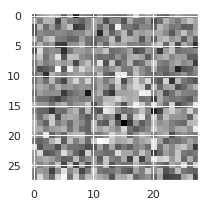

In [22]:
pic_n = 1
fig, ax = plt.subplots(pic_n, 1, sharex = True, sharey = True, figsize=(3, 5))
for i in range(pic_n):
    ax.imshow(data.x_train[250].reshape([28, 28]), 'gray')

In [23]:
import pickle
with open('./temp_acquisition/loo.pkl', 'rb') as f:
    loo = pickle.load(f)
    loo_values = loo['loo']
with open('./temp_acquisition/mem_tmc_0000.pkl', 'rb') as f:
    tmc = pickle.load(f)
    tmc_values = np.mean(tmc['mem_tmc'], 0)
print(loo_values, tmc_values)

[ 0.006  0.    -0.001  0.     0.004 -0.001  0.001  0.     0.     0.   ] [4.58833333e-03 8.91666667e-04 2.72000000e-03 2.83333333e-05
 1.04000000e-03 7.00000000e-04 2.02166667e-03 1.06666667e-03
 3.14166667e-03 1.13333333e-03]


In [24]:
# knn shapley
kmin = 1
kmax = 10
kinterval = 11
knn_values = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))]
knn_values_idx = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))]
loo_knn_values = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))]
loo_knn_values_idx = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))]

for i, k in enumerate(range(kmin, kmax, kinterval)):
    print("neighbour number:", k)
    knn_values[i], *_ = old_knn_shapley(k, x_train, x_test, y_train, y_test)
    loo_knn_values[i], *_ = loo_knn_shapley(k, x_train, x_test, y_train, y_test)

neighbour number: 5


In [25]:
print(len(knn_values[0]))
# # print(knn_values[0][:250])
mean = np.mean(knn_values[0])
print(mean)
# # print(knn_values[0][-250:]*1000)
# # print(np.mean(knn_values[0]))
len(np.where(knn_values[0]<mean)[0])

middle_train = np.where(knn_values[0])
middle_label = np.zeros(len(knn_values[0]))

100
0.00426


In [26]:
# print(knn_values[0][:250])
# print(fc1_knn_values[0][:50])
print(knn_values[0][:10])
knn_values[0] = knn_values[0] / np.linalg.norm(knn_values[0])
print(knn_values[0][:10])


print(loo_knn_values[0][:10])
loo_knn_values[0] = loo_knn_values[0] / np.linalg.norm(loo_knn_values[0])
print(loo_knn_values[0][-10:])

print(tmc_values[:10])
tmc_values = tmc_values / np.linalg.norm(tmc_values)
print(tmc_values[-10:])

print(loo_values[:10])
loo_values = loo_values / np.linalg.norm(loo_values)
print(loo_values[-10:])

[0.00095727 0.00151152 0.00113116 0.00135286 0.00129667 0.00122879
 0.00118899 0.00163157 0.00085072 0.00145097]
[0.01569703 0.0247854  0.01854842 0.02218372 0.02126236 0.02014924
 0.01949672 0.02675393 0.01394979 0.0237926 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.14268254 0.17121904 0.02853651 0.14268254 0.25682857 0.05707301
 0.11414603 0.31390158 0.17121904 0.08560952]


In [27]:
# get high value data
tmc_values_idx = np.where(tmc_values > -100.0)[0]
loo_values_idx = np.where(loo_values > -100.0)[0]
print(tmc_values_idx.shape, loo_values_idx.shape)
for i in range(len(knn_values)):
    knn_values_idx[i] = np.where(knn_values[i] > -100.00000)[0]
    loo_knn_values_idx[i] = np.where(loo_knn_values[i] > -100.00000)[0]

    print("knn_values:", len(knn_values_idx[i]))
    print("loo_knn_values:", len(loo_knn_values_idx[i]))

(100,) (100,)
knn_values: 100
loo_knn_values: 100


In [28]:
# train a random froest model and calucalte the new data
model_name = "RandomForestReg"
# model_name = "mlpreg"
clf_tmc = return_model(model_name)
clf_tmc.fit(x_train[tmc_values_idx], tmc_values[tmc_values_idx])
clf_loo = return_model(model_name)
clf_loo.fit(x_train[loo_values_idx], loo_values[loo_values_idx])

clf_knn = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))]
clf_loo_knn = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))]

for i in range(len(knn_values)):
    clf_knn[i] = return_model(model_name)
    clf_knn[i].fit(x_train[knn_values_idx[i]], knn_values[i][knn_values_idx[i]])

for i in range(len(loo_knn_values)):
    clf_loo_knn[i] = return_model(model_name)
    clf_loo_knn[i].fit(x_train[loo_knn_values_idx[i]], loo_knn_values[i][loo_knn_values_idx[i]])
    
loo_pre_score = []
tmc_pre_score = []
knn_pre_score = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))]
loo_knn_pre_score = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))]


# for i in range(test_size):
loo_pre_score = clf_loo.predict(x_pre)
tmc_pre_score = clf_tmc.predict(x_pre)
for i in range(len(knn_values_idx)):
    knn_pre_score[i] = clf_knn[i].predict(x_pre)
    loo_knn_pre_score[i] = clf_loo_knn[i].predict(x_pre)

In [29]:
tmc_pre_idx=np.argsort(tmc_pre_score)
loo_pre_idx=np.argsort(loo_pre_score)

# print(tmc_pre_score[:10])
# print(loo_pre_score[:10])

knn_pre_idx = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))]
loo_knn_pre_idx = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))]

for i in range(len(knn_values)):
    knn_pre_idx[i]=np.argsort(knn_pre_score[i])
    loo_knn_pre_idx[i]=np.argsort(loo_knn_pre_score[i])

    # print(len(knn_pre_idx[0]))

In [30]:
# print((knn_pre_idx[0][:100]))

# print((knn_pre_idx[0][-100:]))

# print(knn_pre_score[0][0])
# print(knn_pre_score[0][658])

# print(tmc_pre_score[:10])

# print(knn_pre_idx[1][:10])
# tknn_pre_idx = np.flip(knn_pre_idx, 1)
# print(tknn_pre_idx[1][-10:])

# print(loo_pre_score[:10])

# print((knn_pre_idx[0][-5:]))
# # knn_pre_idx[0].reverse()
# knn_pre_idx = np.flip(knn_pre_idx, 1)
# print((knn_pre_idx[0][:5]))
print(loo_pre_idx)

[1955 1748 1587 ... 1919 1988 1783]


In [41]:
# add new data to the train set and draw the picture
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=True

def plot_acquisition(loo_pre_idx, tmc_pre_idx, knn_pre_idx, loo_knn_pre_idx, kmin, kmax, kinterval, x_train, y_train, 
                     x_test, y_test, x_pre, y_pre, HtoL=False):
    sns.set()
    plt.figure()    
    # set the model deterministic
    seed = 0
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    plt.xlabel('Number of added training points')
    plt.ylabel('Prediction accuracy (%)')
    
    tmc_accs = []
    loo_knn_accs = [[] for _ in range(len(knn_values))]   
    knn_accs = [[] for _ in range(len(knn_values))]   
    marks = ['o-', '*-', 's-', 'v-', '^-', '.-', '1-', '2-']
    colors = ['b', 'g', 'r', 'y', 'c', 'm', 'olive', 'pink']
    labels = [i for i in range(kmin, kmax, kinterval)]
    count = int(len(x_pre)/2)
    interval = int(count*0.02)
    x = np.arange(0, count, interval)
#     model = 'logistic'
    model = 'RandomForest'

#     # random solution
    times = 5
    all_rand_accs = []
    print("random")
    for time in range(times):
        
        random_accs = []
        keep_idxs = np.arange(0, count)
        random.shuffle(keep_idxs)
        for j in range(0, count, interval):
            x_train_keep = np.concatenate((x_train, x_pre[keep_idxs[:j]]), axis=0)
            y_train_keep = np.concatenate((y_train, y_pre[keep_idxs[:j]]), axis=0)
            clf_random = return_model(model)
            clf_random.fit(x_train_keep, y_train_keep)
            acc = clf_random.score(x_test, y_test) *100
            random_accs.append(acc)
        all_rand_accs.append(random_accs)
    all_rand_accs = np.mean(all_rand_accs, 0)
    print("random:", all_rand_accs.tolist())
    plt.plot(x, all_rand_accs, 'o-', label='random', color='red')  

    if(HtoL == True):
        print("adding data from Highest to Lowest!")
        knn_pre_idx = np.flip(knn_pre_idx, 1)
        loo_knn_pre_idx = np.flip(loo_knn_pre_idx, 1)
        tmc_pre_idx = np.flip(tmc_pre_idx, 0)
        loo_pre_idx = np.flip(loo_pre_idx, 0)        
    else:
        print("adding data from Lowest to Highest!")
        
    # TMC Shapley
    tmc_accs = []
    idxs = tmc_pre_idx
    for j in range(0, int(count), interval):
        x_train_keep = np.concatenate((x_train, x_pre[idxs[:j]]), axis=0)
        y_train_keep = np.concatenate((y_train, y_pre[idxs[:j]]), axis=0)       
        clf_tmc = return_model(model)
        clf_tmc.fit(x_train_keep, y_train_keep)
        acc = clf_tmc.score(x_test, y_test) * 100
        tmc_accs.append(acc)
    print("TMC:", tmc_accs)
    plt.plot(x, tmc_accs, 's-', label='TMC Shapley', color='olive')

    # Loo Shapley
    loo_accs = []
    idxs = loo_pre_idx
    for j in range(0, int(count), interval):
        x_train_keep = np.concatenate((x_train, x_pre[idxs[:j]]), axis=0)
        y_train_keep = np.concatenate((y_train, y_pre[idxs[:j]]), axis=0)       
        clf_loo = return_model(model)
        clf_loo.fit(x_train_keep, y_train_keep)
        acc = clf_loo.score(x_test, y_test) * 100
        loo_accs.append(acc)
    print("LOO: ", loo_accs)
    plt.plot(x, loo_accs, '^-', label='LOO', color='pink')

    # Knn Shapley  
    for i in tqdm_notebook(range(len(knn_pre_idx)), total=len(knn_pre_idx), leave = False):
        idxs = knn_pre_idx[i]
        for j in tqdm_notebook(range(0, count, interval), total=int(count/interval), leave=False):
            x_train_keep = np.concatenate((x_train, x_pre[idxs[:j]]), axis=0)
            y_train_keep = np.concatenate((y_train, y_pre[idxs[:j]]), axis=0)       
            clf_knn = return_model(model)
            clf_knn.fit(x_train_keep, y_train_keep)
            acc = clf_knn.score(x_test, y_test) * 100
            knn_accs[i].append(acc)
    for i in range(0, len(knn_pre_idx)):
        print(x, knn_accs[i])
        plt.plot(x, knn_accs[i], marks[i], label="Knn Shapley, K="+str(labels[i]), color=colors[i])
        
        
        # LOO KNN
    for i in tqdm_notebook(range(len(loo_knn_pre_idx)), total=len(loo_knn_pre_idx), leave = False):
        idxs = loo_knn_pre_idx[i]
        for j in tqdm_notebook(range(0, int(count), interval), total=int(count/interval), leave=False):
            x_train_keep = np.concatenate((x_train, x_pre[idxs[:j]]), axis=0)
            y_train_keep = np.concatenate((y_train, y_pre[idxs[:j]]), axis=0)       
            clf_knn = return_model(model)
            clf_knn.fit(x_train_keep, y_train_keep)
            acc = clf_knn.score(x_test, y_test) * 100
            loo_knn_accs[i].append(acc)
    for i in range(0, len(loo_knn_pre_idx)):
        print(x, loo_knn_accs[i])
        plt.plot(x, loo_knn_accs[i], marks[i+2], label="LOO Knn Shapley, K="+str(labels[i]), color=colors[i+2])        
        
        
    plt.legend()
    plt.tight_layout()
    if(HtoL == True):
        plt.savefig('knnH-L.png')
    else:
        plt.savefig('knnL-H.png')

random
random: [55.4, 55.9, 56.379999999999995, 56.85999999999999, 56.7, 57.080000000000005, 58.98, 58.86, 60.160000000000004, 60.96, 60.48, 60.98, 58.660000000000004, 60.06, 60.5, 59.98, 61.04, 59.11999999999999, 59.160000000000004, 58.64, 58.5, 58.8, 59.28000000000001, 60.11999999999999, 57.88000000000001, 59.39999999999999, 58.71999999999999, 57.6, 56.98, 60.7, 59.2, 58.839999999999996, 59.739999999999995, 58.65999999999999, 58.120000000000005, 59.46, 57.739999999999995, 58.48, 57.23999999999999, 58.48, 59.4, 57.11999999999999, 58.32000000000001, 57.5, 58.160000000000004, 58.17999999999999, 58.1, 57.339999999999996, 58.17999999999999, 56.98]
adding data from Highest to Lowest!
TMC: [55.400000000000006, 61.6, 61.8, 62.1, 59.8, 60.699999999999996, 62.4, 61.8, 63.3, 62.7, 64.60000000000001, 63.4, 66.4, 67.10000000000001, 64.4, 62.1, 66.8, 69.6, 68.30000000000001, 67.30000000000001, 71.5, 66.0, 67.5, 69.5, 66.0, 68.7, 70.7, 71.5, 70.89999999999999, 69.6, 69.5, 69.1, 69.6, 65.7, 69.3, 68

[  0  20  40  60  80 100 120 140 160 180 200 220 240 260 280 300 320 340
 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700
 720 740 760 780 800 820 840 860 880 900 920 940 960 980] [55.400000000000006, 56.2, 57.4, 61.8, 64.8, 66.4, 67.80000000000001, 71.1, 71.7, 71.0, 73.2, 75.0, 75.9, 74.0, 78.10000000000001, 77.7, 74.3, 78.7, 76.5, 77.2, 78.2, 79.9, 79.4, 78.3, 78.7, 78.10000000000001, 79.7, 79.9, 81.69999999999999, 82.3, 79.5, 79.9, 80.5, 79.9, 80.80000000000001, 81.0, 80.5, 78.2, 79.2, 80.5, 78.10000000000001, 81.10000000000001, 81.3, 79.9, 80.80000000000001, 82.6, 78.7, 82.3, 82.5, 82.0]


[  0  20  40  60  80 100 120 140 160 180 200 220 240 260 280 300 320 340
 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700
 720 740 760 780 800 820 840 860 880 900 920 940 960 980] [55.400000000000006, 59.5, 61.8, 62.6, 65.7, 62.7, 67.5, 67.7, 70.5, 68.5, 69.89999999999999, 71.39999999999999, 71.3, 71.1, 69.19999999999999, 69.19999999999999, 70.1, 67.5, 71.89999999999999, 71.3, 69.19999999999999, 70.8, 70.39999999999999, 72.6, 70.89999999999999, 72.8, 72.8, 70.19999999999999, 73.1, 74.4, 72.3, 71.8, 74.5, 74.1, 73.2, 75.1, 74.7, 75.1, 77.10000000000001, 75.2, 75.5, 75.4, 74.1, 74.7, 77.10000000000001, 75.4, 76.8, 78.4, 75.6, 76.9]


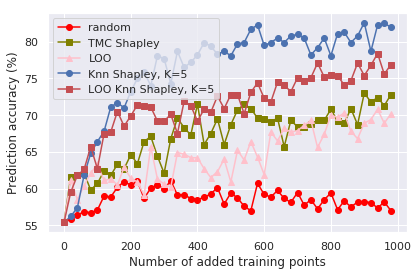

In [42]:
%matplotlib inline
plot_acquisition(loo_pre_idx, tmc_pre_idx, knn_pre_idx, loo_knn_pre_idx, kmin, kmax, kinterval, x_train, y_train, x_heldout, 
                 y_heldout, x_pre, y_pre, HtoL=True)

In [34]:
rand = [54.53, 59.709999999999994, 66.66, 69.01, 71.16, 72.45, 73.75, 75.27000000000001, 75.72, 77.63, 77.97, 79.08, 78.60000000000001, 80.46, 80.47, 81.52000000000001, 80.10000000000001, 82.08, 82.35, 82.52000000000001]
knn_plot = [54.53, 62.480000000000004, 70.45, 75.8, 79.66, 79.83, 79.25, 79.03, 79.53, 79.53, 78.94, 79.06, 80.17, 80.62, 80.10000000000001, 80.16, 80.94, 80.35, 80.5, 80.42]
knn_loo = [54.53, 60.540000000000006, 68.26, 69.51, 70.42, 71.1, 72.68, 73.61, 75.35, 75.11, 75.44, 76.35, 77.74, 77.11, 77.42, 78.14, 78.63, 79.41, 79.14999999999999, 81.21000000000001]



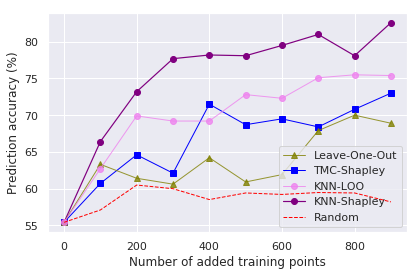

In [78]:
sns.set()
plt.figure()  
plt.xlabel('Number of added training points')
plt.ylabel('Prediction accuracy (%)')
count = 1000
#     print(count)
interval = int(count*0.02)
dele = 0
epochs = 15
x = np.arange(0, count, interval)

rand = [55.4, 55.9, 56.379999999999995, 56.85999999999999, 56.7, 57.080000000000005, 58.98, 58.86, 60.160000000000004, 60.96, 60.48, 60.98, 58.660000000000004, 60.06, 60.5, 59.98, 61.04, 59.11999999999999, 59.160000000000004, 58.64, 58.5, 58.8, 59.28000000000001, 60.11999999999999, 57.88000000000001, 59.39999999999999, 58.71999999999999, 57.6, 56.98, 60.7, 59.2, 58.839999999999996, 59.739999999999995, 58.65999999999999, 58.120000000000005, 59.46, 57.739999999999995, 58.48, 57.23999999999999, 58.48, 59.4, 57.11999999999999, 58.32000000000001, 57.5, 58.160000000000004, 58.17999999999999, 58.1, 57.339999999999996, 58.17999999999999, 56.98]

tmc_plot = [55.400000000000006, 61.6, 61.8, 62.1, 59.8, 60.699999999999996, 62.4, 61.8, 63.3, 62.7, 64.60000000000001, 63.4, 66.4, 67.10000000000001, 64.4, 62.1, 66.8, 69.6, 68.30000000000001, 67.30000000000001, 71.5, 66.0, 67.5, 69.5, 66.0, 68.7, 70.7, 71.5, 70.89999999999999, 69.6, 69.5, 69.1, 69.6, 65.7, 69.3, 68.4, 68.4, 68.8, 69.3, 69.3, 70.8, 69.19999999999999, 68.89999999999999, 70.89999999999999, 68.7, 73.0, 71.8, 72.39999999999999, 71.3, 72.8]

loo_plot = [55.400000000000006, 61.199999999999996, 58.5, 60.4, 62.1, 63.3, 61.1, 61.3, 60.5, 62.9, 61.4, 60.9, 59.099999999999994, 65.7, 61.3, 60.6, 60.199999999999996, 64.9, 64.7, 64.2, 64.2, 62.7, 61.5, 62.3, 64.0, 60.9, 65.2, 63.9, 66.4, 64.3, 61.9, 67.7, 66.5, 68.2, 67.7, 67.9, 68.60000000000001, 69.3, 65.60000000000001, 67.4, 70.0, 69.69999999999999, 70.3, 67.80000000000001, 66.8, 68.89999999999999, 69.39999999999999, 70.8, 68.89999999999999, 70.19999999999999]

knn_accs = [55.400000000000006, 56.2, 57.4, 61.8, 64.8, 66.4, 67.80000000000001, 71.1, 71.7, 71.0, 73.2, 75.0, 75.9, 74.0, 78.10000000000001, 77.7, 74.3, 78.7, 76.5, 77.2, 78.2, 79.9, 79.4, 78.3, 78.7, 78.10000000000001, 79.7, 79.9, 81.69999999999999, 82.3, 79.5, 79.9, 80.5, 79.9, 80.80000000000001, 81.0, 80.5, 78.2, 79.2, 80.5, 78.10000000000001, 81.10000000000001, 81.3, 79.9, 80.80000000000001, 82.6, 78.7, 82.3, 82.5, 82.0]

loo_knn_accs = [55.400000000000006, 59.5, 61.8, 62.6, 65.7, 62.7, 67.5, 67.7, 70.5, 68.5, 69.89999999999999, 71.39999999999999, 71.3, 71.1, 69.19999999999999, 69.19999999999999, 70.1, 67.5, 71.89999999999999, 71.3, 69.19999999999999, 70.8, 70.39999999999999, 72.6, 70.89999999999999, 72.8, 72.8, 70.19999999999999, 73.1, 74.4, 72.3, 71.8, 74.5, 74.1, 73.2, 75.1, 74.7, 75.1, 77.10000000000001, 75.2, 75.5, 75.4, 74.1, 74.7, 77.10000000000001, 75.4, 76.8, 78.4, 75.6, 76.9]

x_axis = []
rand_axis = []
knn_axis = []
loo_axis = []
loo_knn_axis = []
tmc_axis = []

for i in range(0, len(rand), 5):
    x_axis.append(x[i])
    rand_axis.append(rand[i])
    knn_axis.append(knn_accs[i])
    loo_knn_axis.append(loo_knn_accs[i])
    tmc_axis.append(tmc_plot[i])
    loo_axis.append(loo_plot[i])


plt.plot(x_axis, loo_axis, '^-', label="Leave-One-Out", color="olive", linewidth=1, zorder=4, alpha=0.8)
plt.plot(x_axis, tmc_axis, 's-', label="TMC-Shapley", color="blue", linewidth=1)

# plt.plot(x, g_plot, '-', label="G Shapley", color="olive", linewidth=1)
plt.plot(x_axis, loo_knn_axis, 'o-', label="KNN-LOO", color="violet", zorder=6, alpha=0.8, linewidth=1)
plt.plot(x_axis, knn_axis, 'o-', label="KNN-Shapley", color="purple", linewidth=1.2)
plt.plot(x_axis, rand_axis, '--', label="Random", color="red", linewidth=1, zorder=7)

# plt.title('Digits Classification\n Random Forest Classifier')

plt.legend(loc=4)
plt.tight_layout()
plt.savefig('DataAcquisitionMnist.png') 
